# Logistic Regression #

Objectives: build an iterative algorithm to learn how to discriminate images of cats using a logistic regression classification model. We will perform gradient descent and experiment with one important hyperparameter called the learning rate.

> **Instructions:** ensure your Python environment is setup with the following packages: 
>
> - `matplotlib` is used to display images and plot graphs
> - `PIL` and `skimage` is used to perform some image processing operations
> - `h5py` is used to import dataset from H5 files 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from skimage.transform import resize

np.set_printoptions(precision=2, suppress=True)
%matplotlib inline

***

## A. Preparing your Dataset ##

A common pre-processing step in deep learning is to normalise the dataset. First, one computes the mean and standard deviation over the entire set. Then, the mean is subtracted from each item. Finally, data is scaled by the standard deviation. 

For image datasets, RGB pixel values are represented with 3 integers in the range of 0 to 255. A simpler pre-processing strategy that yields similar performance, is to divide each item by 255. 

Our dataset is stored in a single file called `catsvsnoncats.h5`. It is a collection of images labelled with ground truth information i.e. $y=1$ for the cat class and $y=0$ for the non-cat class. All images are of shape $(W, H, 3)$ where $W=H=64$ i.e. small square RGB images. We will first write a function to load and preprocess the dataset such that each row represents an image whose pixels values are in the range (0,1). Our dataset is split in 2 sets, one for training and one for test.

> <font color='darkgreen'>**Exercise 1:**</font> Reshape and scale both datasets so that images are flattened into a single vector of shape $(3\times W\times H)$ where all item features are within the unit range. Note that a numpy array of shape $(N1,N2,N3,N4)$ can be flattened in an array of shape $(N1, N2\times N3\times N4)$ using:<br/>

> ```python A_flattened = A.reshape(A.shape[0], -1)```

In [12]:
def load_dataset(filepath='datasets/catsvsnoncats.h5'):
    """
    Load and pre-process dataset
    
    Arguments:
    filepath -- string, dataset path

    Returns:
    (X_train, Y_train), (X_test, Y_test), classes -- training and test datasets
    """

    h5file = h5py.File(filepath, "r")
    X_train = np.array(h5file["X_train"][:])
    X_test = np.array(h5file["X_test"][:])
    Y_train = np.array(h5file["Y_train"][:])
    Y_test = np.array(h5file["Y_test"][:])
    classes = np.array(h5file["Classes"][:]) 
    h5file.close()

    # Reshape and scale datasets containing N_train and N_test mages such that
    # X_train.shape = (n_train, W * H * 3)
    # X_test.shape = (n_test, W * H * 3)
    # Y_train.shape = (n_train, 1)
    # X_test.shape = (n_test, 1)
    # Scale X_train and X_test from range {0..255} to (0,1)
    
    ### INPUT YOUR CODE HERE ### (4 lines)
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    Y_train = Y_train.reshape(Y_train.shape[0], -1)
    Y_test = Y_test.reshape(Y_test.shape[0], -1)
    ### END OF YOUR CODE SEGMENT ###

    return (X_train, Y_train), (X_test, Y_test), classes

In [13]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/catsvsnoncats.h5')
print("classes: 0={} 1={}".format(classes[0].decode(), classes[1].decode()))
print("sanity check: ({},{:.1f})".format(X_train[-1].min(),X_train[-1].max()))

classes: 0=not_cat 1=cat
sanity check: (0.0,1.0)


> ***Expected Output:***
>
> `classes: 0=not_cat 1=cat`<br/>
> `sanity check: (0.0,1.0)`

***

To visualize a random image from the training set, evaluate the following cell.

image class: not_cat


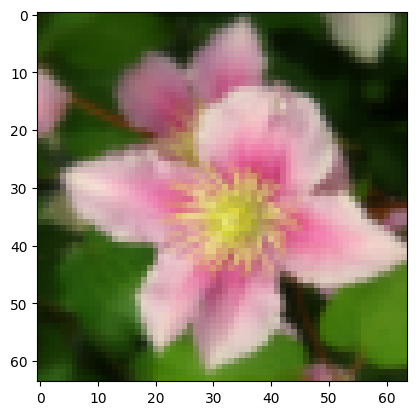

In [14]:
# Visualise a random picture from training set
import random
index = random.randint(0, Y_train.shape[0])
print("image class: {}".format(classes[int(Y_train[index, 0])].decode()))
_ = plt.imshow(X_train[index].reshape(64,64,3))

Many issues in deep learning can be resolved by inspecting tensor shapes, ensuring that matrices or vectors have appropriate dimensions.

***

> <font color='darkgreen'>**Exercise 2:**</font> Explore dataset dimensions.<br/> 

Find the values for the number of images in the datasets and the number of features per image.

In [17]:
### INPUT YOUR CODE HERE ### (3 lines)
n_train = X_train.shape[0]
n_test = X_test.shape[0]
feature_count = X_train.shape[1]
### END OF YOUR CODE SEGMENT ###

print("training set: {} images".format(n_train))
print("test set: {} images".format(n_test))
print("features per image: {} pixel values".format(feature_count))

training set: 209 images
test set: 50 images
features per image: 12288 pixel values


> ***Expected Output:***
>
> `training set: 209 images`<br/>
`test set: 50 images`<br/>
`features per image: 12288 pixel values`<br/>

## B. Logistic Regression using Backprop ##

Logistic regression can be understood as a simple neural network:

<img src="figs/LogisticRegression.png" style="width:800px">

Given a normalised input $x$ (row vector), the logistic regression prediction is given by $\hat{y} = \sigma({x\, w + b})\notag$, where $w$ (column vector) and $b$ (scalar) denotes the model parameters. The cross-entropy loss is obtained from: 
$$\ell(y, \hat{y}) =  - y  \log(\hat{y}) - (1-y)  \log(1-\hat{y})\notag$$

The overall loss for $n$ training examples is computed from the sum all individual losses:

$$ \mathcal{L} = \frac{1}{n} \sum_{i=1}^n \ell(y^{(i)}, \hat{y}^{(i)})\tag{1}$$

To implement the logistic regression using backprop, we will take the following steps:

- Implement the sigmoid helper function
- Initialise model weights and bias
- Evaluate model prediction loss using forward propagation (inference)
- Train model by updating parameters from gradients (backprop) 
- Evaluate model performance on test dataset

***
> <font color='darkgreen'>**Exercise 3:**</font> Implement the sigmoid function using numpy

In [18]:
# Sigmoid vectorial function
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- scalar or numpy array of any size

    Returns:
    s -- sigmoid(x), scalar or numpy array of any size
    """
    
    ### INPUT YOUR CODE HERE ### (1 line)
    s = 1 / (1 + np.exp(-x))
    ### END OF YOUR CODE SEGMENT ###  
    
    return s

In [19]:
print("sigmoid([-1, 0, 1]) = {}".format(sigmoid(np.array([-1, 0,1]))))

sigmoid([-1, 0, 1]) = [0.27 0.5  0.73]


> ***Expected Output:***
>
> `sigmoid([-1, 0, 1]) = [0.27 0.5  0.73]`

***

> <font color='darkgreen'>**Exercise 4:**</font> Initialise the regression weights and bias to zero.<br> Hint: look up `np.zeros()` in numpy library.

In [24]:
# Model parameter initialisation
def init_model_parameters(dim):
    """
    Initialise weights and bias to 0
    
    Argument:
    dim -- size of vector w (i.e. number of model parameters)
    
    Returns:
    w -- initialised weights: column vector of shape (dim, 1)
    b -- initialised bias: scalar
    """
    
    ### INPUT YOUR CODE HERE ### (2 lines)
    w = np.zeros((dim,1))
    b = 0
    ### END OF YOUR CODE SEGMENT ###  

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [25]:
dim = 2
w, b = init_model_parameters(dim)
print("w.T = {}".format(w.T))
print("b = {}".format(b))

w.T = [[0. 0.]]
b = 0


> ***Expected Output:***
>
> `w.T = [[0. 0.]]`<br/>
`b = 0`

***

> <font color='darkgreen'>**Exercise 5:**</font> Compute the forward propagation. Return gradients and loss. 
>
> Note $X$ is matrix of $n$ training examples stacked in rows. The regression output can be understood as the activation of the output node of a neural network: $A = \sigma(Z) = \sigma(X\,w + b)$ of shape $n\times 1$. $\hat{Y} = \mathbb{1}_{\{ A > 1/2 \}}$ is the logistic regression predictions for the $n$ training examples (column vector).
>
> From equation (1), the total loss can be expressed as  $\mathcal{L}=-\frac{1}{n}(Y^T \log\hat{Y}+(1-Y)^T\log(1-\hat{Y}))$.
>
> The two gradients are provided:
>
> $$ \frac{\partial \mathcal{L}}{\partial w} = \frac{1}{n}X^T(\hat{Y}-Y)\notag$$
> $$ \frac{\partial \mathcal{L}}{\partial b} = \frac{1}{n} \sum_{i=1}^n (\hat{Y}_i-Y_i)\notag$$
>
> Complete the function below.

In [26]:
# Forward propagation
def forward_prop(w, b, X, Y):
    """
    Compute the logistic regression loss and its gradient

    Arguments:
    w -- weight vector, a numpy array of shape (W * H * 3, 1)
    b -- bias, a scalar
    X -- n data samples (n, W * H * 3)
    Y -- ground truth vector (0=dog, 1=cat) of size (n, 1)

    Return:
    loss -- negative log-likelihood loss for logistic regression
    dw -- gradient of the loss with respect to w, same shape as w
    db -- gradient of the loss with respect to b, same shape as b
    """
    
    n = X.shape[0]
    
    # Forward prop: compute loss from (X, Y)
    ### INPUT YOUR CODE HERE ### (2 lines)
    Y_hat = sigmoid(np.dot(X, w) + b) # Compute Activation, shape (n, 1)
    loss = -(1/n) * np.sum(Y*np.log(Y_hat) + (1-Y)*np.log(1-Y_hat)) # Compute cross entropy loss (scalar)
    ### END OF YOUR CODE SEGMENT ###  

    loss = np.squeeze(loss)
    assert(loss.shape == ())
    
    # Compute gradients for backprop
    ### INPUT YOUR CODE HERE ### (2 lines)
    dw = (1/n) * np.dot(X.T, (Y_hat - Y))
    db = (1/n) * np.sum(Y_hat - Y)
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    return {"dw": dw, "db": db}, loss

In [27]:
w, b, X, Y = np.array([[1., 2.]]).T, 2., np.array([[1., 2.], [3., -3.], [-2., -1.]]), np.array([[1,1,0]]).T

grads, loss = forward_prop(w, b, X, Y)
np.set_printoptions(precision=3, suppress=True)
print("dw.T = {}".format(grads["dw"].T))
print("db = {:.3f}".format(grads["db"]))
print("loss = {:.3f}".format(loss))

dw.T = [[-0.811  0.691]]
db = -0.204
loss = 0.480


> ***Expected Output:***
>
> `dw.T = [[-0.811  0.691]]`<br/>
`db = -0.204`<br/>
`loss = 0.480`

***

To train the logistic regression (i.e. fit data in training set), we perform a gradient descent, updating our model parameters, $\theta \equiv (w, b)$, iteratively. Such optimisation requires to compute the loss over the training set for the current values of our model parameters $\theta$ and then update these parameters values according to the following rule:  $\theta=\theta-\lambda\,d\theta$ where $\lambda$ is an hyperparameter scalar called the learning rate. This is generally repeated for a number of iterations described by another optimisation hyperparameter referred to as the epoch count or epochs (1 epoch = a complete presentation of training data).

> <font color='darkgreen'>**Exercise 6:**</font> Complete the function below to train your logistic regression model parameters $(w, b)$.

In [28]:
# Parameter optimisation using backprop
def model_fit(w, b, X, Y, epochs, learning_rate):
    """
    Optimise w and b by performing gradient descent
    
    Arguments:
    w -- weight vector, a numpy array of shape (W * H * 3, 1)
    b -- bias, a scalar
    X -- n data samples (n, W * H * 3)
    Y -- ground truth vector (0=dog, 1=cat) of size (n, 1)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    
    Returns:
    params -- dictionary with optimised weights and bias
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    loss_log = []
    for i in range(epochs):
        ### INPUT YOUR CODE HERE ### (5 lines)
        grads, loss = forward_prop(w, b, X, Y) # Cost and gradient computation
        dw = grads["dw"] # derivative from grads
        db = grads["db"] # derivative from grads
        w = w - learning_rate * dw # weights update
        b = b - learning_rate * db # bias update
        ### END OF YOUR CODE SEGMENT ###  
        
        # logs
        if i % 100 == 0:
            loss_log.append(loss)
            print("Loss after {} iterations: {:.3f}".format(i, loss))
        
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, loss_log

In [29]:
params, grads, losses = model_fit(w, b, X, Y, epochs=800, learning_rate=0.008)
print("w.T = {}".format(params["w"].T))
print("b = {:.3f}".format(params["b"]))
print("dw.T = {}".format(grads["dw"].T))
print("db = {:.3f}".format(grads["db"]))

Loss after 0 iterations: 0.480
Loss after 100 iterations: 0.116
Loss after 200 iterations: 0.064
Loss after 300 iterations: 0.046
Loss after 400 iterations: 0.037
Loss after 500 iterations: 0.031
Loss after 600 iterations: 0.027
Loss after 700 iterations: 0.024
w.T = [[1.958 1.429]]
b = 2.110
dw.T = [[-0.05   0.011]]
db = 0.004


> ***Expected Output:***
>
>`Loss after 0 iterations: 0.480`<br/>
`Loss after 100 iterations: 0.116`<br/>
`Loss after 200 iterations: 0.064`<br/>
`Loss after 300 iterations: 0.046`<br/>
`Loss after 400 iterations: 0.037`<br/>
`Loss after 500 iterations: 0.031`<br/>
`Loss after 600 iterations: 0.027`<br/>
`Loss after 700 iterations: 0.024`<br/>
`w.T = [[1.958 1.429]]`<br/>
`b = 2.110`<br/>
`dw.T = [[-0.05   0.011]]`<br/>
`db = 0.004`

***

Once the model parameters are optimised, we can use our logistic regression model to predict labels on our dataset `X_test`. 

> <font color='darkgreen'>**Exercise 7:**</font> Implement the `model_predict()` function by computing the activation for input $X$ and converting them to predictions (0/1 values). Avoid python iteration and `if` statements prefering numpy vectorial code.

In [30]:
# Model inference
def model_predict(w, b, X):
    '''
    Predict class label using logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of shape (W * H * 3, 1)
    b -- bias, a scalar
    X -- n data samples (n, W * H * 3)
    
    Returns:
    Y_hat -- vector with class predictions for examples in X
    '''
    n = X.shape[0]

    ### INPUT YOUR CODE HERE ### (2 lines)
    A = sigmoid(np.dot(X, w) + b) # Compute Activation, shape (n, 1)
    Y_hat = (A >= 0.5).astype(int) # Convert activations to {0,1} predictions
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(Y_hat.shape == (n, 1))    
    return Y_hat

In [31]:
w, b, X = np.array([[0.1, -0.2]]).T, 0.2, np.array([[1., 2], [3., -1.], [-2, -3]])
print("predictions.T = {}".format(model_predict(w, b, X).T))

predictions.T = [[0 1 1]]


> ***Expected Output:***
>
> `predictions = [[0 1 1]]`

## C. Stiching it all together ##

We can now fit all the previous steps into a regression model function that will take our traning and testing dataset as input along with two hyper-parameters (learning rate and number of epochs for training) and that will return the optimised model parameters along training and testing logs useful to study the training behaviour of our gradient optimisation. 

> <font color='darkgreen'>**Exercise 8:**</font> Implement the following function and evaluate your model on our datasets

In [32]:
# Logistic regression model
def logistic_regression_model(X_train, Y_train, X_test, Y_test, epochs=2000, learning_rate=0.5):
    '''
    Build, train and evalaute the logistic regression model
    
    Arguments:
    X_train -- training set a numpy array of shape (n_train, W * H * 3)
    Y_train -- training groud truth vector (0=dog, 1=cat) of size (n_train, 1)
    X_test -- testing set a numpy array of shape (n_test, W * H * 3)
    Y_test -- testing groud truth vector (0=dog, 1=cat) of size (n_test, 1)
    epochs -- number of iteration updates through dataset for training (hyperparameter)
    learning_rate -- learning rate of the gradient descent (hyperparameter)
    
    Returns:
    model -- dictionary with model parameters, training logs and testing results
    '''
    
    ### INPUT YOUR CODE HERE ### (5 lines)
    dim = X_train.shape[1]
    w, b = np.zeros((dim, 1)), 0
    params, grads, losses = model_fit(w, b, X_train, Y_train, epochs, learning_rate)
    Y_hat_train = model_predict(params["w"], params["b"], X_train)
    Y_hat_test = model_predict(params["w"], params["b"], X_test)
    ### END OF YOUR CODE SEGMENT ###  

    print("{:.1f}% training acc.".format(100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))))
    print("{:.1f}% test acc.".format(100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))))
    
    model = {"w": params["w"], "b": params["b"], "losses": losses, "LR": learning_rate,
            "Y_hat_test": Y_hat_test, "Y_hat_train": Y_hat_train}
    
    return model

In [33]:
np.random.seed(2019)
model = logistic_regression_model(X_train, Y_train, X_test, Y_test, epochs=1000, learning_rate=0.005)

Loss after 0 iterations: 0.693
Loss after 100 iterations: 0.585
Loss after 200 iterations: 0.467
Loss after 300 iterations: 0.376
Loss after 400 iterations: 0.331
Loss after 500 iterations: 0.303
Loss after 600 iterations: 0.280
Loss after 700 iterations: 0.260
Loss after 800 iterations: 0.243
Loss after 900 iterations: 0.228
96.7% training acc.
72.0% test acc.


> ***Expected Output:***
> 
> `Loss after 0 iterations: 0.693`<br/>
`Loss after 100 iterations: 0.585`<br/>
`Loss after 200 iterations: 0.467`<br/>
`Loss after 300 iterations: 0.376`<br/>
`Loss after 400 iterations: 0.331`<br/>
`Loss after 500 iterations: 0.303`<br/>
`Loss after 600 iterations: 0.280`<br/>
`Loss after 700 iterations: 0.260`<br/>
`Loss after 800 iterations: 0.243`<br/>
`Loss after 900 iterations: 0.228`<br/>
`96.7% training acc.`<br/>
`72.0% test acc.`

***

**Note** that the training loss decreases regularly and the training accuracy reached the high nineties after 1000 epochs. This tends to indicate that the model has sufficient capacity to fit the training data. Test error is at 72%, which is a good performance for such a simple classifier.

In DL, parameter initialisation and training procedure often rely on random number generators. It is good practive to set the seed of the pseudo-random number generator so that your results are reproducable.

You can visualise misclassification errors by evaluating the following code.

In [ ]:
# Example of misclassification
misclassified_images = np.where(model["Y_hat_test"][:,-1] != Y_test[:,-1])[-1]
index = misclassified_images[random.randint(0, misclassified_images.shape[0] - 1)]

print("image class: {}".format(classes[int(Y_test[index, :])].decode()))
print("predicted class: {}".format(classes[int(model["Y_hat_test"][index, :])].decode()))
_ = plt.imshow(X_test[index].reshape(64,64,3))

I had to clear the output. Here is the useful part :  

image class: cat  
predicted class: not_cat

(image of a cat)

It is also useful to monitor the logs of your traning sessions by plotting the loss as function of the epoch count. Evaluate the following code and observe how the loss decreases. If you increase the number of iterations, you could further increase training accuracy but at the cost of test accuracy which will start decreasing. This phenomenon is known as overfitting.

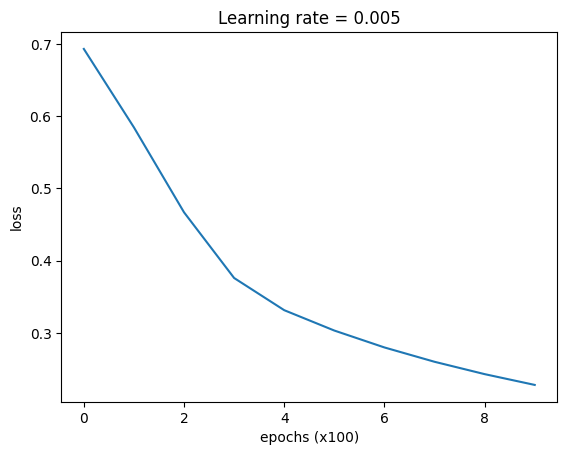

In [35]:
# Plot the learning curve
loss_logs = np.squeeze(model['losses'])
plt.plot(loss_logs)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(model['LR']))
plt.show()

Choosing hyperparameter values is often very important to achieve optimal performance for your model. In particular the learning rate $\lambda$ will determine how fast we may converge to the optimal parameter values. If $\lambda$ is too large, we may overshoot the optimal value resulting in poor perfomance while choosing a very small value can result in a slow algorithm. Experiment with the following code and observe the training behaviours.

Loss after 0 iterations: 0.693
Loss after 100 iterations: 0.824
Loss after 200 iterations: 0.419
Loss after 300 iterations: 0.617
Loss after 400 iterations: 0.522
Loss after 500 iterations: 0.388
Loss after 600 iterations: 0.236
Loss after 700 iterations: 0.154
Loss after 800 iterations: 0.135
Loss after 900 iterations: 0.125
Loss after 1000 iterations: 0.116
Loss after 1100 iterations: 0.109
Loss after 1200 iterations: 0.103
Loss after 1300 iterations: 0.097
Loss after 1400 iterations: 0.092
Loss after 1500 iterations: 0.087
Loss after 1600 iterations: 0.083
Loss after 1700 iterations: 0.079
Loss after 1800 iterations: 0.076
Loss after 1900 iterations: 0.073
99.5% training acc.
70.0% test acc.
Loss after 0 iterations: 0.693
Loss after 100 iterations: 0.591
Loss after 200 iterations: 0.556
Loss after 300 iterations: 0.529
Loss after 400 iterations: 0.507
Loss after 500 iterations: 0.488
Loss after 600 iterations: 0.471
Loss after 700 iterations: 0.456
Loss after 800 iterations: 0.442
L

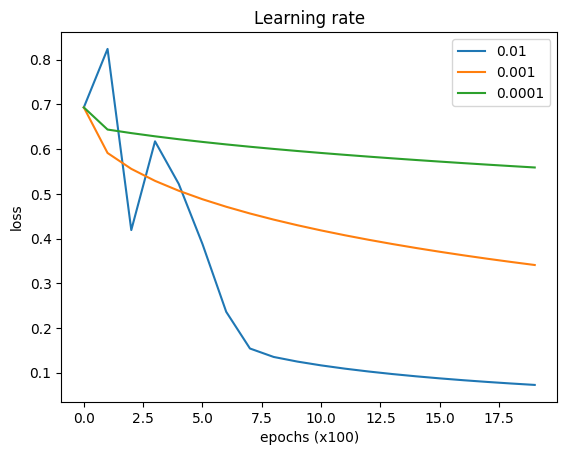

In [36]:
# Investigate other learning rates
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for lr in learning_rates:
    models[str(lr)] = logistic_regression_model(X_train, Y_train, X_test, Y_test, epochs=2000, learning_rate=lr)
    plt.plot(np.squeeze(models[str(lr)]["losses"]), label= str(models[str(lr)]["LR"]))
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.legend(loc='upper right')
plt.title("Learning rate")
plt.show()

Our logistic regression model performs quite well on this small dataset. However our classification problem is simple ; amoung natural images, cats have some distinctive features that can form some strong indicators for our classifier. Let's now see how our model performs on a larger dataset of images of only dogs and cats. Run the following code and observe how the performance drops significantly (this may take a few minutes to complete). Our model is too simple to achieve good performance. A well trained deep convolutional neural network would typically achieve a testing accuracy in the high nineties.

Loss after 0 iterations: 0.693
Loss after 100 iterations: 2.165
Loss after 200 iterations: 2.030
Loss after 300 iterations: 1.940
Loss after 400 iterations: 1.875
Loss after 500 iterations: 1.824
Loss after 600 iterations: 1.781
Loss after 700 iterations: 1.742
Loss after 800 iterations: 1.706
Loss after 900 iterations: 1.673
Loss after 1000 iterations: 1.642
Loss after 1100 iterations: 1.613
Loss after 1200 iterations: 1.585
Loss after 1300 iterations: 1.559
Loss after 1400 iterations: 1.534
Loss after 1500 iterations: 1.510
Loss after 1600 iterations: 1.487
Loss after 1700 iterations: 1.466
Loss after 1800 iterations: 1.445
Loss after 1900 iterations: 1.424
Loss after 2000 iterations: 1.405
Loss after 2100 iterations: 1.386
Loss after 2200 iterations: 1.367
Loss after 2300 iterations: 1.350
Loss after 2400 iterations: 1.332
Loss after 2500 iterations: 1.315
Loss after 2600 iterations: 1.298
Loss after 2700 iterations: 1.282
Loss after 2800 iterations: 1.266
Loss after 2900 iterations

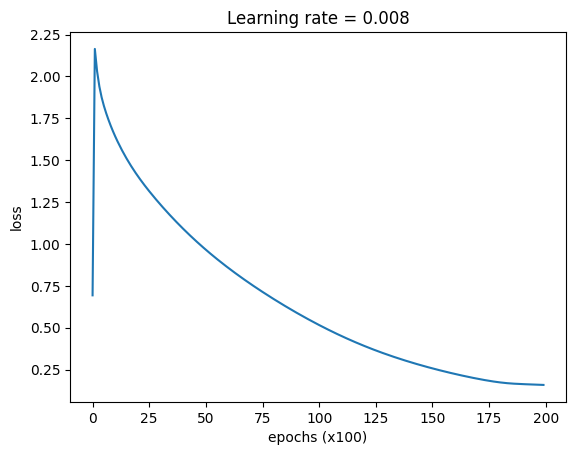

In [38]:
# Experiment with a more challenging dataset: dogs vs. cats
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/dogsvscats.h5')
model = logistic_regression_model(X_train, Y_train, X_test, Y_test, 
                                  epochs=20000, learning_rate=0.008)

# Plot the learning curve
loss_logs = np.squeeze(model['losses'])
plt.plot(loss_logs)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(model['LR']))
plt.show()

-- EOF --